# Identifying the shallowest ansatz that learns the 4-site Schwinger model

In [1]:
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit

sys.path.append('..')
from pnp_ansatze import make_Agate, make_pnp_ansatz
from rttgen import CNOTBasedRtt
from cx_decomposition import cx_circuit
from model_circuits import single_step, two_steps
from trotter import trotter_step_circuits
from observables import plot_counts_with_curve, plot_curve, number_density

## Target state circuits

In [2]:
def make_step_circuits(num_sites, aJ, am, omegadt, backend, physical_qubits):
    qubit_pairs = list(zip(range(0, num_sites - 1), range(1, num_sites)))
  
    if backend.configuration().simulator:
        rtts = dict((qubits, CNOTBasedRtt(backend, qubits)) for qubits in qubit_pairs)
        cxs = dict((qubits, cx_circuit(backend, *qubits)) for qubits in qubit_pairs)
        cxs.update((qubits[::-1], cx_circuit(backend, *qubits[::-1])) for qubits in qubit_pairs)
    else:
        rtts = dict((qubits, PulseEfficientCR(backend, (physical_qubits[qubits[0]], physical_qubits[qubits[1]]))) for qubits in qubit_pairs)
        cxs = dict((qubits, cx_circuit(backend, physical_qubits[qubits[0]], physical_qubits[qubits[1]])) for qubits in qubit_pairs)
        cxs.update((qubits[::-1], cx_circuit(backend, physical_qubits[qubits[1]], physical_qubits[qubits[0]])) for qubits in qubit_pairs)

    single_step_circuit = single_step(num_sites, aJ, am, omegadt, rtts=rtts, cxs=cxs)
    two_step_circuit = two_steps(num_sites, aJ, am, omegadt, rtts=rtts, cxs=cxs)
    
    return single_step_circuit, two_step_circuit

In [3]:
num_sites = 4
aJ = 1.
am = 0.5
omegadt = 0.2
# aJ = 0.7
# am = 0.439
# omegadt = 0.167
num_tstep = 6

backend = Aer.get_backend('statevector_simulator')
physical_qubits = None

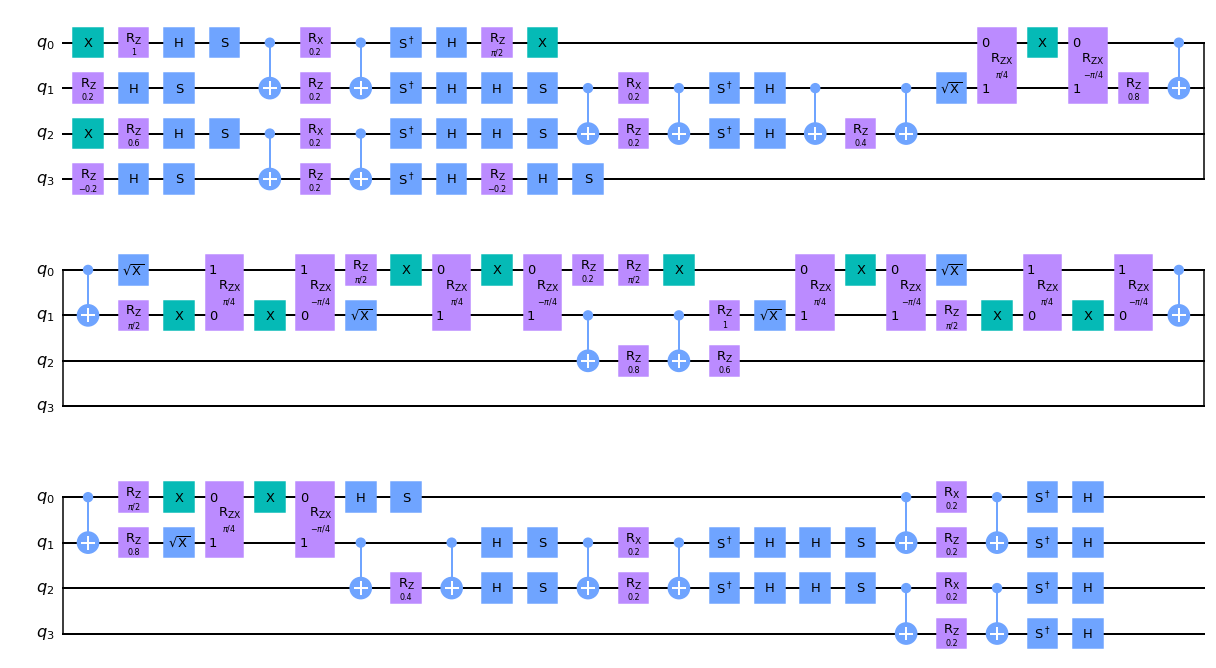

In [4]:
forward_circuits = make_step_circuits(num_sites, aJ, am, omegadt, backend, physical_qubits)
initial_state = QuantumCircuit(num_sites)
initial_state.x([0, 2])
target_circuits = trotter_step_circuits(num_tstep, forward_circuits, initial_state=initial_state, measure=False)
target_circuits[1].draw('mpl')

## 12 parameters

/usr/local/lib/python3.8/dist-packages/sympy/core/expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


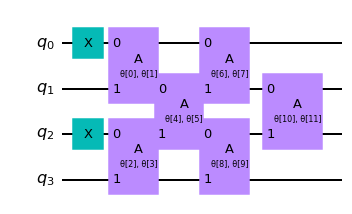

In [5]:
approximator = make_pnp_ansatz(num_qubits=num_sites, num_layers=num_sites // 2, initial_x_positions=[0, 2])
approximator.draw('mpl')

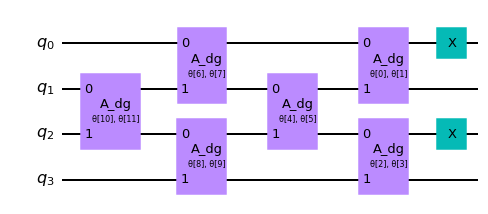

In [6]:
uncomputer_12params = approximator.inverse()
uncomputer_12params.draw('mpl')

## 10 parameters

There is a priori no rule on the placement of the A gates in the ansatz. Additionally, the positioning of the Xs at the end of the uncomputer is also arbitrary; as long as the number of Xs match the weight ("particle number") of the target circuit, a sufficiently deep ansatz should be able to uncompute the circuit. Given these two points, if the 12-parameter ansatz above can learn to uncompute the target circuit, one can suppose that an ansatz of the following form should perform equally well:

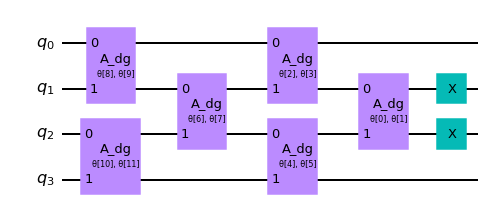

In [7]:
uncomputer = make_pnp_ansatz(num_qubits=num_sites, num_layers=num_sites // 2, initial_x_positions=[1, 2], structure=[(1, 2), (0, 1), (2, 3)]).inverse()
uncomputer.draw('mpl')

However, owing to the property of the A gate and the fact that the observable (global / local cost function) is composed of only Z and I operators, the last A gates in the uncomputer followed by adjacent Xs or Is become equivalent to identity in the calculation of the cost functions. Therefore the above ansatz is functionally identical to the following:

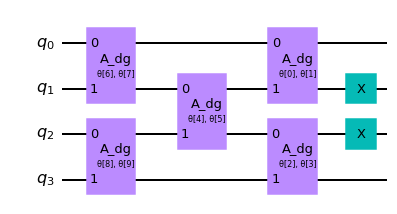

In [8]:
uncomputer_10params = make_pnp_ansatz(num_qubits=num_sites, num_layers=num_sites // 2, initial_x_positions=[1, 2], structure=[(1, 2), (0, 1), (2, 3)], first_layer_structure=[(0, 1), (2, 3)]).inverse()
uncomputer_10params.draw('mpl')

## 8 parameters

Following the same logic, if we move the two Xs in the original 12-parameter ansatz to the last two qubits, one ends up with the following:

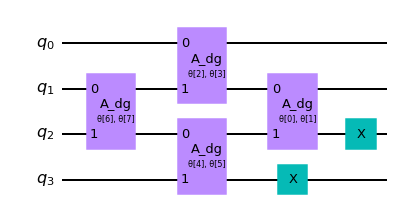

In [9]:
uncomputer_8params = make_pnp_ansatz(num_qubits=num_sites, num_layers=num_sites // 2, initial_x_positions=[2, 3], structure=[(0, 1), (2, 3), (1, 2)], first_layer_structure=[(1, 2)]).inverse()
uncomputer_8params.draw('mpl')

## Trying the ansatze out

We now test the three ansatze on 8 Trotter steps of the Schwinger model individually.

In [10]:
import multiprocessing
import scipy.optimize as sciopt
from qiskit.quantum_info import Operator

def make_approximator(num_params, param_name=None):
    if num_params == 12:
        return make_pnp_ansatz(num_qubits=num_sites, num_layers=num_sites // 2, initial_x_positions=[0, 2], param_name=param_name)
    elif num_params == 10:
        return make_pnp_ansatz(num_qubits=num_sites, num_layers=num_sites // 2, initial_x_positions=[1, 2], structure=[(1, 2), (0, 1), (2, 3)], first_layer_structure=[(0, 1), (2, 3)], param_name=param_name)
    elif num_params == 8:
        return make_pnp_ansatz(num_qubits=num_sites, num_layers=num_sites // 2, initial_x_positions=[2, 3], structure=[(0, 1), (2, 3), (1, 2)], first_layer_structure=[(1, 2)], param_name=param_name)

def run_minimization(istep, num_params, queue):
    backend = Aer.get_backend('statevector_simulator')
    single_step_circuit, two_step_circuit = make_step_circuits(num_sites, aJ, am, omegadt, backend, physical_qubits)
    initial_state = QuantumCircuit(num_sites)
    initial_state.x([0, 2])
    target_circuit = trotter_step_circuits(istep + 1, single_step_circuit, two_step_circuit, initial_state=initial_state, measure=False)[istep]

    uncomputer = make_approximator(num_params).inverse()

    compiler_circuit = target_circuit.compose(uncomputer, inplace=False)
    
    def fun(x):
        return 1. - np.square(np.abs(Operator(compiler_circuit.assign_parameters(dict(zip(compiler_circuit.parameters, x)))).data[0, 0]))
    
    initial_param_val = np.ones(len(compiler_circuit.parameters)) * np.pi / 2.
    res = sci un, initial_param_val)

    queue.put((istep, num_params, res.success, res.fun, res.x))

def driver():
    procs = dict()
    queue = multiprocessing.Queue()
    for istep in range(8):
        for num_params in [8, 10, 12]:
            proc = multiprocessing.Process(target=run_minimization, args=(istep, num_params, queue))
            proc.start()
            procs[(istep, num_params)] = proc
            
    results = dict((num_params, dict()) for num_params in [8, 10, 12])
        
    while len(procs) != 0:
        istep, num_params, success, fun, x = queue.get()
        procs.pop((istep, num_params)).join()
        results[num_params][istep] = (success, fun, x)
        
    return results

In [11]:
results = driver()

for num_params in [8, 10, 12]:
    print([(istep, x[0]) for istep, x in results[num_params].items()])
    
for num_params in [8, 10, 12]:
    print([(istep, x[1]) for istep, x in results[num_params].items()])

[(0, True), (1, True), (2, True), (3, True), (4, True), (5, True), (6, True), (7, True)]
[(0, True), (1, True), (6, True), (3, True), (5, True), (4, True), (2, True), (7, True)]
[(0, True), (1, True), (2, True), (3, True), (5, True), (6, True), (7, True), (4, True)]
[(0, 0.005750333114692752), (1, 0.04466809835402741), (2, 0.0826838972225431), (3, 0.06500651975822369), (4, 0.03236076966900381), (5, 0.0057960691876332016), (6, 0.0018775517675776454), (7, 0.010717670990962769)]
[(0, 6.379787159038752e-05), (1, 0.000254696966936252), (6, 0.006435231002129171), (3, 0.006071402098570822), (5, 9.16129847772229e-06), (4, 0.006302762686405616), (2, 0.0020662721002217), (7, 0.006294057272216769)]
[(0, 3.701467638450584e-05), (1, 2.2348034534047656e-10), (2, 8.938139117731225e-11), (3, 2.253710551514132e-10), (5, 1.869889576511241e-09), (6, 1.9775181492320826e-10), (7, 6.811951003271588e-11), (4, 3.0168756381954154e-11)]


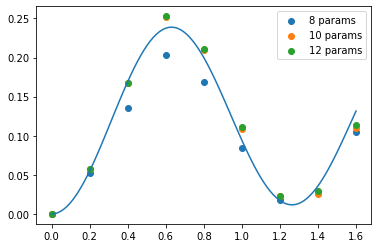

In [12]:
probs_list_exact = plot_curve(num_sites, aJ, am, omegadt * 8)

for num_params in [8, 10, 12]:
    approximator = make_approximator(num_params)
    probs_list = [probs_list_exact[0]]
    for istep in range(8):
        circuit = approximator.assign_parameters(dict(zip(approximator.parameters, results[num_params][istep][2])))
        probs = np.square(np.abs(Operator(circuit).data[:, 0]))
        probs_list.append((probs, 0))

    densities, _ = number_density(probs_list, num_toys=0)
    plt.scatter(np.arange(9) * omegadt, densities, label='{} params'.format(num_params))
    
plt.legend()

## Building on 10 parameters

Eight-parameter version seems to lack the necessary depth. Ten-parameter version appears to have a sufficiently high expressibility. Is it good enough for RQD?

In [17]:
initial_state = QuantumCircuit(num_sites)
initial_state.x([0, 2])

target_circuit = initial_state.compose(two_step_circuit)

approximator = make_approximator(10, param_name='T')
uncomputer = make_approximator(10).inverse()

results = []

for _ in range(2, 10, 2):
    compiler_circuit = target_circuit.compose(uncomputer, inplace=False)
    
    def fun(x):
        return 1. - np.square(np.abs(Operator(compiler_circuit.assign_parameters(dict(zip(compiler_circuit.parameters, x)))).data[0, 0]))
    
    initial_param_val = np.ones(len(compiler_circuit.parameters)) * np.pi / 2.
    res = sciopt.minimize(fun, initial_param_val)

    results.append((res.success, res.fun, res.x))
    
    target_circuit = approximator.assign_parameters(dict(zip(approximator.parameters, res.x))).compose(two_step_circuit)

print(results)

[(True, 0.000254696966936252, array([0.77735551, 1.28947255, 1.57190216, 1.54261424, 1.12276829,
       2.40712386, 2.06761142, 1.64450759, 1.19820024, 1.10853849])), (True, 0.0021697766029195042, array([ 11.31448024,   1.97819189, -17.34218485,   2.04844858,
         3.14168589,   1.64545847,  -3.57467075,   0.0302608 ,
       -17.71184091,   0.03035357])), (True, 0.0005235814811288542, array([ 1.65073855,  5.00858306,  1.30342015,  2.78284385,  1.77941927,
       -0.86880487,  0.06628786,  2.24061278,  1.9566043 ,  2.66223252])), (True, 0.0021695356393819365, array([0.16853047, 1.73386463, 1.42388466, 0.51192887, 1.24085115,
       2.22688289, 1.45154579, 0.67259826, 1.2015127 , 1.02605851]))]


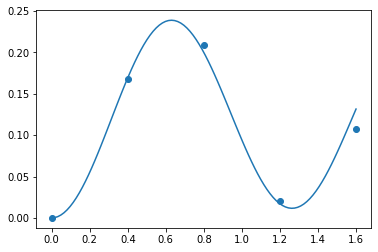

In [20]:
plot_curve(num_sites, aJ, am, omegadt * 8)
probs_list = [probs_list_exact[0]]
for _, _, x in results:
    circuit = approximator.assign_parameters(dict(zip(approximator.parameters, x)))
    probs = np.square(np.abs(Operator(circuit).data[:, 0]))
    probs_list.append((probs, 0))

densities, _ = number_density(probs_list, num_toys=0)
plt.scatter(np.arange(0, 10, 2) * omegadt, densities, label='{} params'.format(num_params))